In [ ]:
import torch
## image classifcation code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
! unzip "/content/drive/MyDrive/Oranges/oranges diesease 5 class.v1i.coco-segmentation.zip"

Archive:  /content/drive/MyDrive/Oranges/oranges diesease 5 class.v1i.coco-segmentation.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
  inflating: test/_annotations.coco.json  
 extracting: test/bgmold3_png.rf.3045be179eed18eddf2088b4e128817d.jpg  
 extracting: test/green1_png.rf.f799ece2a162d9e09427a4d1eaf33f75.jpg  
 extracting: test/green5_png.rf.ef124bb60bdbfe87a0384c2465ed0496.jpg  
 extracting: test/green9_png.rf.b56f388436881bcc8ec7b28cf4bf2684.jpg  
 extracting: test/rot_png.rf.5683669e16d96e442883bdb4b153d808.jpg  
   creating: train/
 extracting: train/S-M-10_png.rf.616aec2f1a40e801b2e6943199ac2c79.jpg  
 extracting: train/S-M-10_png.rf.69e41ef34c193d3d2fa3495c1af81cf9.jpg  
 extracting: train/S-M-10_png.rf.8629a34e233bc18e186d45c644868bb8.jpg  
 extracting: train/S-M-11_png.rf.39348da479929f831b7e94429775e0bd.jpg  
 extracting: train/S-M-11_png.rf.b78d15000a3e1648826acfd5964a2f4e.jpg  
 extracting: train/S-M-11_png.rf.da59

In [ ]:
!pip install albumentations pycocotools segmentation-models-pytorch tqdm optuna -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose)
from albumentations.pytorch import ToTensorV2

In [ ]:
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, coco, root_dir, transforms=None):
        self.coco = coco
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
      image_id = self.image_ids[index]
      image_info = self.coco.loadImgs(image_id)[0]
      path = os.path.join(self.root_dir, image_info['file_name'])
      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
      anns = self.coco.loadAnns(ann_ids)
      mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)

      for ann in anns:
          mask = np.maximum(self.coco.annToMask(ann) * ann['category_id'], mask)

      if self.transforms:
          augmented = self.transforms(image=image, mask=mask)
          image = augmented['image']
          mask = augmented['mask']

      return image, mask.long()  # Ensure mask is converted to Long type

# Paths and other constants
train_root_dir = "/content/train"  # Directory containing training images
test_root_dir = "/content/valid"    # Directory containing testing images
ann_file_train = "/content/train/_annotations.coco.json"
ann_file_test = "/content/valid/_annotations.coco.json"

# Loading COCO datasets
coco_train = COCO(ann_file_train)
coco_test = COCO(ann_file_test)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Define Augmentations
def get_transforms(phase):
    if phase == 'train':
        return Compose([
            Resize(256, 256),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return Compose([
            Resize(256, 256),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

train_dataset = COCODataset(coco=coco_train, root_dir=train_root_dir, transforms=get_transforms('train'))
test_dataset = COCODataset(coco=coco_test, root_dir=test_root_dir, transforms=get_transforms('test'))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
import segmentation_models_pytorch as smp
NUM_CLASSES = 8

In [ ]:
weigts_encoders = {
    "timm-efficientnet-b8":"imagenet",
    "vgg19_bn":"imagenet",
    "mit_b5":"imagenet",
    "resnext101_32x8d":"ssl",
    "timm-regnety_160":"imagenet",
    "timm-regnetx_160":"imagenet",
    "densenet161":"imagenet",
    "inceptionresnetv2":"imagenet",
    "timm-mobilenetv3_large_100":"imagenet"
}
finetuned_models_paths = []

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

# Define the model again to use the best hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def run_training(encoder="vgg19_bn",weights="imagenet"):
  model = smp.Unet(
      encoder_name=encoder,        # You can choose different ResNet versions like resnet50, resnet101
      encoder_weights=weights,     # Use ImageNet pre-trained weights
      in_channels=3,                  # Input channels (RGB)
      classes=NUM_CLASSES,            # Number of output classes
  ).to(device)

  # Define the loss function and optimizer with the best hyperparameters
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0005552883801334075, weight_decay=5.006620560688584e-05)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

  # Training loop
  num_epochs = 25
  best_model_wts = None
  best_loss = float('inf')

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for inputs, masks in tqdm(train_loader):
          inputs = inputs.to(device)
          masks = masks.to(device).long()  # Ensure masks are of type Long

          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
              outputs = model(inputs)
              loss = criterion(outputs, masks)
              loss.backward()
              optimizer.step()

          running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(train_loader.dataset)
      scheduler.step(epoch_loss)

      print(f'Epoch {epoch}/{num_epochs} - Loss: {epoch_loss}')

      # Save the best model
      if epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = model.state_dict()

  # Load the best model weights and save the model
  model.load_state_dict(best_model_wts)
  model_path = f"best_unet_{encoder}_model.pth"
  torch.save(model.state_dict(), model_path)
  finetuned_models_paths.appned(model_path)
  print("Model saved as best_unet_resnet_model.pth")


for key,values in weigts_encoders.items():
    run_training(key,value)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 276MB/s]
100%|██████████| 7/7 [07:33<00:00, 64.80s/it]


Epoch 0/25 - Loss: 2.0283315215791973


100%|██████████| 7/7 [07:26<00:00, 63.76s/it]


Epoch 1/25 - Loss: 1.4904522714160737


100%|██████████| 7/7 [07:36<00:00, 65.18s/it]


Epoch 2/25 - Loss: 1.1704911481766473


100%|██████████| 7/7 [07:17<00:00, 62.46s/it]


Epoch 3/25 - Loss: 0.9644397826421829


100%|██████████| 7/7 [07:18<00:00, 62.60s/it]


Epoch 4/25 - Loss: 0.8177197757221404


100%|██████████| 7/7 [07:27<00:00, 63.98s/it]


Epoch 5/25 - Loss: 0.670138438542684


100%|██████████| 7/7 [07:16<00:00, 62.38s/it]


Epoch 6/25 - Loss: 0.558298842396055


100%|██████████| 7/7 [07:23<00:00, 63.42s/it]


Epoch 7/25 - Loss: 0.47625712440127416


100%|██████████| 7/7 [07:27<00:00, 63.93s/it]


Epoch 8/25 - Loss: 0.423557056983312


100%|██████████| 7/7 [07:27<00:00, 63.98s/it]


Epoch 9/25 - Loss: 0.38944605219931827


100%|██████████| 7/7 [07:22<00:00, 63.24s/it]


Epoch 10/25 - Loss: 0.35605519697779703


100%|██████████| 7/7 [07:10<00:00, 61.44s/it]


Epoch 11/25 - Loss: 0.31342398183686393


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import cv2
import numpy as np
import torch

def preprocess_image(image_path, transform):
    """
    Preprocess the input image for model inference.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image)
    image = augmented['image'].unsqueeze(0)  # Add batch dimension
    return image.to(device)

def predict(model, image_tensor):
    """
    Perform inference using the trained model.
    """
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
    return output

def load_model(model_path, num_classes=NUM_CLASSES):
    """
    Load the saved model for inference.
    """
    model = smp.Unet(
        encoder_name="efficientnet-b5",
        encoder_weights=None,  # No pre-trained weights needed as we're loading our trained model
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def visualize_output(output):
    import matplotlib.pyplot as plt
    plt.imshow(output, cmap='gray')
    plt.show()

# Visualize the raw output before argmax
def predict_and_visualize(model, image_tensor):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        visualize_output(output[0].cpu().numpy())  # Visualize raw output (first class map)
        output = torch.argmax(output, dim=1)
        output = output.cpu().squeeze(0).numpy()
    return output


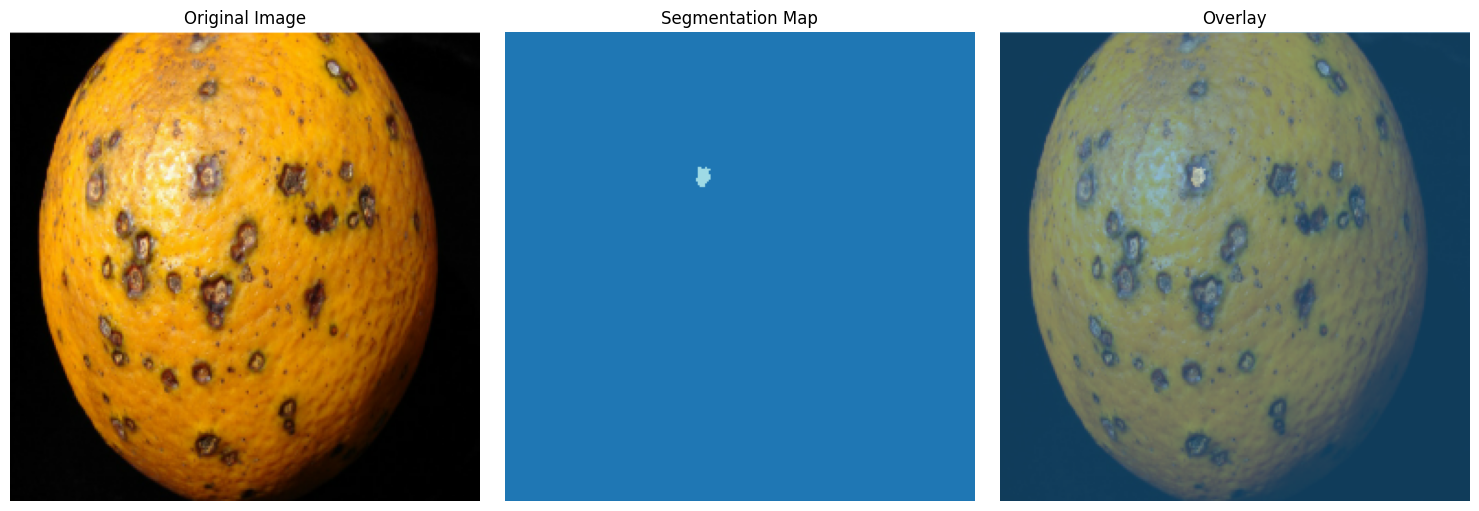

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_segmentation(image, prediction, num_classes):
    """
    Visualize the segmentation result.

    :param image: Original image (numpy array)
    :param prediction: Model prediction (numpy array)
    :param num_classes: Number of classes in the segmentation
    """
    # Ensure image and prediction have the same dimensions
    image = cv2.resize(image, (prediction.shape[1], prediction.shape[0]))

    # Create a color map
    colors = plt.colormaps['tab20'](np.linspace(0, 1, num_classes))

    # Create a colored segmentation map
    segmentation_map = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for i in range(num_classes):
        segmentation_map[prediction == i] = (colors[i][:3] * 255).astype(np.uint8)

    # Overlay the segmentation map on the original image
    alpha = 0.5
    overlay = cv2.addWeighted(image, 1 - alpha, segmentation_map, alpha, 0)

    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(segmentation_map)
    plt.title('Segmentation Map')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
model_path = "best_unet_resnet_model.pth"
image_path = "/content/Typical-black-spot-lesions-on-Valencia-sweet-orange-caused-by-Guignardia-citricarpa.png"

# Load the trained model
model = load_model(model_path)

# Define the same transformations used during testing
test_transform = Compose([
    Resize(256, 256),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image.copy()

augmented = test_transform(image=image)
image_tensor = augmented['image'].unsqueeze(0).to(device)

# Perform prediction
output = predict(model, image_tensor)

# Convert output to numpy and apply argmax
prediction = output.argmax(dim=1).squeeze().cpu().numpy()

# Visualize the result
visualize_segmentation(original_image, prediction, NUM_CLASSES)